In [12]:
import pandas as pd
import duckdb
import numpy as np


In [13]:
%load_ext sql
%sql duckdb:///:memory:
%config SqlMagic.displaylimit = 0
%config SqlMagic.autopandas = True

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [14]:
%%sql 
INSTALL spatial;
LOAD spatial;

Running query in 'duckdb:///:memory:'

,Success


In [15]:

%%sql BENCHMARK <<
drop table if exists BENCHMARK;
CREATE TABLE BENCHMARK AS 
    SELECT * FROM st_read('../BENCHMARK_KSA-study-histological-groundtruth Master.xlsx', layer = 'BENCHMARK', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])

Running query in 'duckdb:///:memory:'

    filter out the NOK and ST11 as it does not have an entry in the contingency table

In [16]:
%%sql BENCHMARK_ok <<
drop table if exists BENCHMARK_ok;
create table BENCHMARK_ok as
    select * from BENCHMARK
    where Comment = 'ok' AND Studies_ID != 'ST11' AND Studies_ID != '45' AND Studies_ID != 'ST1' AND Studies_ID != 'ST10' AND Studies_ID != '7875886';

select * from BENCHMARK_ok

Running query in 'duckdb:///:memory:'

# Get the number of patients with a TBx Gleason score of >= 3:

In [17]:
%%sql TBx_score_greatereq_1 <<

select 
Studies_ID,
other_aval_ID,
Site,
Comment,
TBx_Re_Base,
TBx_Re_Mid,
TBx_Re_Apex,
TBx_Li_Base,
TBx_Li_Mid,
TBx_Li_Apex,
TBx_Li_lateral,
TBx_Li_medial,
TBx_Re_lateral,
TBx_Re_medial

from BENCHMARK_ok
where TBx_Re_Base >= 1 OR TBx_Re_Mid >= 1 OR TBx_Re_Apex >= 1 OR TBx_Li_Base >= 1 OR TBx_Li_Mid >= 1 OR TBx_Li_Apex >= 1 OR TBx_Li_lateral >= 1 OR TBx_Li_medial >= 1 OR TBx_Re_lateral >= 1 OR TBx_Re_medial >= 1

Running query in 'duckdb:///:memory:'

In [18]:
def make_true_false(value):
    if value != None:
        return value
    return 'No TBx'


In [19]:
TBx_score_greatereq_1=TBx_score_greatereq_1.rename(columns = {'TBx_Li_lateral':'TBx_Li_Lateral',
                                                              'TBx_Li_medial':'TBx_Li_Medial',
                                                              'TBx_Re_lateral':'TBx_Re_Lateral',
                                                              'TBx_Re_medial':'TBx_Re_Medial'})

In [20]:
TBx_score_greatereq_1['TBx_Re_Base'] = TBx_score_greatereq_1['TBx_Re_Base'].apply(make_true_false)
TBx_score_greatereq_1['TBx_Re_Mid'] = TBx_score_greatereq_1['TBx_Re_Mid'].apply(make_true_false)
TBx_score_greatereq_1['TBx_Re_Apex'] = TBx_score_greatereq_1['TBx_Re_Apex'].apply(make_true_false)
TBx_score_greatereq_1['TBx_Li_Base'] = TBx_score_greatereq_1['TBx_Li_Base'].apply(make_true_false)
TBx_score_greatereq_1['TBx_Li_Mid'] = TBx_score_greatereq_1['TBx_Li_Mid'].apply(make_true_false)
TBx_score_greatereq_1['TBx_Li_Apex'] = TBx_score_greatereq_1['TBx_Li_Apex'].apply(make_true_false)
TBx_score_greatereq_1['TBx_Li_Lateral'] = TBx_score_greatereq_1['TBx_Li_Lateral'].apply(make_true_false)
TBx_score_greatereq_1['TBx_Li_Medial'] = TBx_score_greatereq_1['TBx_Li_Medial'].apply(make_true_false)
TBx_score_greatereq_1['TBx_Re_Lateral'] = TBx_score_greatereq_1['TBx_Re_Lateral'].apply(make_true_false)
TBx_score_greatereq_1['TBx_Re_Medial'] = TBx_score_greatereq_1['TBx_Re_Medial'].apply(make_true_false)

In [21]:

for column in TBx_score_greatereq_1.columns:
    sum = 0
    for rowname in TBx_score_greatereq_1.index:
        if TBx_score_greatereq_1.loc[rowname,column] == '':
            continue

        if TBx_score_greatereq_1.loc[rowname,column] in ['1','2','3','4','5','6','7','8','9','10']:
            sum = sum + 1
    TBx_score_greatereq_1.loc['Number_of_TBx_greaterequal_1',column] = sum

In [22]:
#Number of patients per Site with a Gleason score >=1:
sum_ksa = 0
sum_bellinzona = 0
sum_triemli = 0

for Case in TBx_score_greatereq_1.index:
    if TBx_score_greatereq_1.loc[Case,'Site'] == 'KSA':
        sum_ksa = sum_ksa + 1
    if TBx_score_greatereq_1.loc[Case,'Site'] == 'Bellinzona':
        sum_bellinzona = sum_bellinzona + 1
    if TBx_score_greatereq_1.loc[Case,'Site'] == 'Triemli':
        sum_triemli = sum_triemli + 1   

print('Number of Cases with TBx (Gleason score >= 1) at site KSA: ' + str(sum_ksa))
print('Number of Cases with TBx (Gleason score >= 1) at site Bellinzona: ' + str(sum_bellinzona))
print('Number of Cases with TBx (Gleason score >= 1) at site Triemli: ' + str(sum_triemli))

Number of Cases with TBx (Gleason score >= 1) at site KSA: 16
Number of Cases with TBx (Gleason score >= 1) at site Bellinzona: 6
Number of Cases with TBx (Gleason score >= 1) at site Triemli: 13


    Get the Manual parts of the contingency tables for each Reader:

In [23]:
%%sql contingency_ksa_reader1 <<
drop table if exists contingency_ksa_reader1;
create table contingency_ksa_reader1 as
    select * from st_read('../20230814_KSA-study_Contingency-Prostate-Areas_Master_moved_entries.xlsx', layer = 'Hospital_A', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])
    where Annotation_Process = 'rad' AND Annotator = 'rad1';

select * from contingency_ksa_reader1

Running query in 'duckdb:///:memory:'

In [24]:
%%sql contingency_ksa_reader2 <<
drop table if exists contingency_ksa_reader2;
create table contingency_ksa_reader2 as
    select * from st_read('../20230814_KSA-study_Contingency-Prostate-Areas_Master_moved_entries.xlsx', layer = 'Hospital_A', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])
    where Annotation_Process = 'rad' AND Annotator = 'rad2';

select * from contingency_ksa_reader2

Running query in 'duckdb:///:memory:'

In [25]:
%%sql contingency_ksa_reader3 <<
drop table if exists contingency_ksa_reader3;
create table contingency_ksa_reader3 as
    select * from st_read('../20230814_KSA-study_Contingency-Prostate-Areas_Master_moved_entries.xlsx', layer = 'Hospital_A', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])
    where Annotation_Process = 'rad' AND Annotator = 'rad3';

select * from contingency_ksa_reader3

Running query in 'duckdb:///:memory:'

In [26]:
%%sql contingency_bellinzona_reader1 <<
drop table if exists contingency_bellinzona_reader1;
create table contingency_bellinzona_reader1 as
    select * from st_read('../20230814_KSA-study_Contingency-Prostate-Areas_Master_moved_entries.xlsx', layer = 'Hospital_B', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])
    where Annotation_Process = 'rad' AND Annotator = 'rad1';

select * from contingency_bellinzona_reader1

Running query in 'duckdb:///:memory:'

In [27]:
%%sql contingency_bellinzona_reader2 <<
drop table if exists contingency_bellinzona_reader2;
create table contingency_bellinzona_reader2 as
    select * from st_read('../20230814_KSA-study_Contingency-Prostate-Areas_Master_moved_entries.xlsx', layer = 'Hospital_B', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])
    where Annotation_Process = 'rad' AND Annotator = 'rad2';

select * from contingency_bellinzona_reader2

Running query in 'duckdb:///:memory:'

In [28]:
%%sql contingency_bellinzona_reader3 <<
drop table if exists contingency_bellinzona_reader3;
create table contingency_bellinzona_reader3 as
    select * from st_read('../20230814_KSA-study_Contingency-Prostate-Areas_Master_moved_entries.xlsx', layer = 'Hospital_B', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])
    where Annotation_Process = 'rad' AND Annotator = 'rad3';

select * from contingency_bellinzona_reader3

Running query in 'duckdb:///:memory:'

In [29]:
%%sql contingency_triemli_reader1 <<
drop table if exists contingency_triemli_reader1;
create table contingency_triemli_reader1 as
    select * from st_read('../20230814_KSA-study_Contingency-Prostate-Areas_Master_moved_entries.xlsx', layer = 'Hospital_', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])
    where Annotation_Process = 'rad' AND Annotator = 'rad1';

select * from contingency_triemli_reader1

Running query in 'duckdb:///:memory:'

In [30]:
%%sql contingency_triemli_reader2 <<
drop table if exists contingency_triemli_reader2;
create table contingency_triemli_reader2 as
    select * from st_read('../20230814_KSA-study_Contingency-Prostate-Areas_Master_moved_entries.xlsx', layer = 'Hospital_', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])
    where Annotation_Process = 'rad'AND Annotator = 'rad2';

select * from contingency_triemli_reader2

Running query in 'duckdb:///:memory:'

In [31]:
%%sql contingency_triemli_reader3 <<
drop table if exists contingency_triemli_reader3;
create table contingency_triemli_reader3 as
    select * from st_read('../20230814_KSA-study_Contingency-Prostate-Areas_Master_moved_entries.xlsx', layer = 'Hospital_', open_options=['HEADERS=FORCE', 'FIELD_TYPES=STRING'])
    where Annotation_Process = 'rad'AND Annotator = 'rad3';

select * from contingency_triemli_reader3

Running query in 'duckdb:///:memory:'

    Add for each sextant and quadrant if the initial reader sent it for biopsy or not. Which means he classified a region as containing a lesion or not.

In [32]:
%%sql benchmark_table <<
--KSA und Bellinzona bedingungen:
with Initial_TBx_Re_Base_positive_KSA_BELLINZONA as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Re_Base_positive 
    from BENCHMARK_ok
    where TBx_Re_Base IS NOT NULL AND TBx_Re_Base >= 1 AND (Site = 'KSA' OR Site = 'Bellinzona')
),

Initial_TBx_Re_Mid_positive_KSA_BELLINZONA as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Re_Mid_positive 
    from BENCHMARK_ok
    where TBx_Re_Mid IS NOT NULL AND TBx_Re_Mid >= 1 AND (Site = 'KSA' OR Site = 'Bellinzona')
),

Initial_TBx_Re_Apex_positive_KSA_BELLINZONA as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Re_Apex_positive 
    from BENCHMARK_ok
    where TBx_Re_Apex IS NOT NULL AND TBx_Re_Apex >= 1 AND (Site = 'KSA' OR Site = 'Bellinzona')
),

Initial_TBx_Li_Base_positive_KSA_BELLINZONA as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Li_Base_positive 
    from BENCHMARK_ok
    where TBx_Li_Base IS NOT NULL AND TBx_Li_Base >= 1 AND (Site = 'KSA' OR Site = 'Bellinzona')
),

Initial_TBx_Li_Mid_positive_KSA_BELLINZONA as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Li_Mid_positive 
    from BENCHMARK_ok
    where TBx_Li_Mid IS NOT NULL AND TBx_Li_Mid >= 1 AND (Site = 'KSA' OR Site = 'Bellinzona')
),

Initial_TBx_Li_Apex_positive_KSA_BELLINZONA as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Li_Apex_positive 
    from BENCHMARK_ok
    where TBx_Li_Apex IS NOT NULL AND TBx_Li_Apex >= 1 AND (Site = 'KSA' OR Site = 'Bellinzona')
),

--Triemli Bedingungen:

Initial_TBx_Li_lateral_positive_TRIEMLI as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Li_Lateral_positive 
    from BENCHMARK_ok
    where TBx_Li_lateral IS NOT NULL AND TBx_Li_lateral >= 1 AND (Site = 'Triemli')
),

Initial_TBx_Li_medial_positive_KSA_TRIEMLI as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Li_Medial_positive 
    from BENCHMARK_ok
    where TBx_Li_medial IS NOT NULL AND TBx_Li_medial >= 1 AND (Site = 'Triemli')
),

Initial_TBx_Re_lateral_positive_KSA_TRIEMLI as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Re_Lateral_positive 
    from BENCHMARK_ok
    where TBx_Re_lateral IS NOT NULL AND TBx_Re_lateral >= 1 AND (Site = 'Triemli')
),

Initial_TBx_Re_medial_positive_KSA_TRIEMLI as (
    select 
    other_aval_ID as key,
    true AS Initial_TBx_Re_Medial_positive 
    from BENCHMARK_ok
    where TBx_Re_medial IS NOT NULL AND TBx_Re_medial >= 1 AND (Site = 'Triemli')
)

select 

Studies_ID,
other_aval_ID,
Site,
Comment,
TBx_Re_Base,
TBx_Re_Mid,
TBx_Re_Apex,
TBx_Li_Base,
TBx_Li_Mid,
TBx_Li_Apex,
TBx_Li_lateral,
TBx_Li_medial,
TBx_Re_lateral,
TBx_Re_medial,
Initial_TBx_Re_Base_positive_KSA_BELLINZONA.Initial_TBx_Re_Base_positive,
Initial_TBx_Re_Mid_positive_KSA_BELLINZONA.Initial_TBx_Re_Mid_positive,
Initial_TBx_Re_Apex_positive_KSA_BELLINZONA.Initial_TBx_Re_Apex_positive,
Initial_TBx_Li_Base_positive_KSA_BELLINZONA.Initial_TBx_Li_Base_positive,
Initial_TBx_Li_Mid_positive_KSA_BELLINZONA.Initial_TBx_Li_Mid_positive,
Initial_TBx_Li_Apex_positive_KSA_BELLINZONA.Initial_TBx_Li_Apex_positive,
Initial_TBx_Li_lateral_positive_TRIEMLI.Initial_TBx_Li_Lateral_positive,
Initial_TBx_Li_medial_positive_KSA_TRIEMLI.Initial_TBx_Li_Medial_positive,
Initial_TBx_Re_lateral_positive_KSA_TRIEMLI.Initial_TBx_Re_Lateral_positive,
Initial_TBx_Re_medial_positive_KSA_TRIEMLI.Initial_TBx_Re_Medial_positive

from BENCHMARK_ok
--KSA und Bellinzona:

left join Initial_TBx_Re_Base_positive_KSA_BELLINZONA on Initial_TBx_Re_Base_positive_KSA_BELLINZONA.key = BENCHMARK_ok.other_aval_ID
left join Initial_TBx_Re_Mid_positive_KSA_BELLINZONA on Initial_TBx_Re_Mid_positive_KSA_BELLINZONA.key = BENCHMARK_ok.other_aval_ID
left join Initial_TBx_Re_Apex_positive_KSA_BELLINZONA on Initial_TBx_Re_Apex_positive_KSA_BELLINZONA.key = BENCHMARK_ok.other_aval_ID
left join Initial_TBx_Li_Base_positive_KSA_BELLINZONA on Initial_TBx_Li_Base_positive_KSA_BELLINZONA.key = BENCHMARK_ok.other_aval_ID
left join Initial_TBx_Li_Mid_positive_KSA_BELLINZONA on Initial_TBx_Li_Mid_positive_KSA_BELLINZONA.key = BENCHMARK_ok.other_aval_ID
left join Initial_TBx_Li_Apex_positive_KSA_BELLINZONA on Initial_TBx_Li_Apex_positive_KSA_BELLINZONA.key = BENCHMARK_ok.other_aval_ID

--Triemli:
left join Initial_TBx_Li_lateral_positive_TRIEMLI on Initial_TBx_Li_Lateral_positive_TRIEMLI.key = BENCHMARK_ok.other_aval_ID
left join Initial_TBx_Li_medial_positive_KSA_TRIEMLI on Initial_TBx_Li_Medial_positive_KSA_TRIEMLI.key = BENCHMARK_ok.other_aval_ID
left join Initial_TBx_Re_lateral_positive_KSA_TRIEMLI on Initial_TBx_Re_Lateral_positive_KSA_TRIEMLI.key = BENCHMARK_ok.other_aval_ID
left join Initial_TBx_Re_medial_positive_KSA_TRIEMLI on Initial_TBx_Re_Medial_positive_KSA_TRIEMLI.key = BENCHMARK_ok.other_aval_ID


Running query in 'duckdb:///:memory:'

    replace NaN with false

In [33]:
def make_true_false(value):
    if value == True:
        return True
    return False

In [34]:
benchmark_table['Initial_TBx_Re_Base_positive'] = benchmark_table['Initial_TBx_Re_Base_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Re_Mid_positive'] = benchmark_table['Initial_TBx_Re_Mid_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Re_Apex_positive'] = benchmark_table['Initial_TBx_Re_Apex_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Li_Base_positive'] = benchmark_table['Initial_TBx_Li_Base_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Li_Mid_positive'] = benchmark_table['Initial_TBx_Li_Mid_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Li_Apex_positive'] = benchmark_table['Initial_TBx_Li_Apex_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Li_Lateral_positive'] = benchmark_table['Initial_TBx_Li_Lateral_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Li_Medial_positive'] = benchmark_table['Initial_TBx_Li_Medial_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Li_Apex_positive'] = benchmark_table['Initial_TBx_Li_Apex_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Re_Lateral_positive'] = benchmark_table['Initial_TBx_Re_Lateral_positive'].apply(make_true_false)
benchmark_table['Initial_TBx_Re_Medial_positive'] = benchmark_table['Initial_TBx_Re_Medial_positive'].apply(make_true_false)

    Set StudyID as index names:

In [35]:
contingency_ksa_reader1 = contingency_ksa_reader1.set_index('Spalte1')
contingency_ksa_reader2 = contingency_ksa_reader2.set_index('Spalte1')
contingency_ksa_reader3 = contingency_ksa_reader3.set_index('Spalte1')

contingency_bellinzona_reader1 = contingency_bellinzona_reader1.set_index('Origin_ID')
contingency_bellinzona_reader2 = contingency_bellinzona_reader2.set_index('Origin_ID')
contingency_bellinzona_reader3 = contingency_bellinzona_reader3.set_index('Origin_ID')

contingency_triemli_reader1 = contingency_triemli_reader1.set_index('Origin_ID')
contingency_triemli_reader2 = contingency_triemli_reader2.set_index('Origin_ID')
contingency_triemli_reader3 = contingency_triemli_reader3.set_index('Origin_ID')

benchmark_table = benchmark_table.set_index('other_aval_ID')

# For the initial readers, False and NaN are all converted to false. Let's make them empty when they should be:

In [36]:
columnnames_sextants = ['Initial_TBx_Re_Base_positive',
            'Initial_TBx_Re_Mid_positive',
            'Initial_TBx_Re_Apex_positive',
            'Initial_TBx_Li_Base_positive',
            'Initial_TBx_Li_Mid_positive',
            'Initial_TBx_Li_Apex_positive'
]

for colname in columnnames_sextants:
    for rowcount, StudyID in enumerate(benchmark_table.index):
        if benchmark_table.loc[StudyID,'Site'] == 'Triemli':
            benchmark_table.loc[StudyID,colname] = ''


columnnames_quadrants = ['Initial_TBx_Li_Lateral_positive',
                         'Initial_TBx_Li_Medial_positive',
                         'Initial_TBx_Re_Lateral_positive',
                        'Initial_TBx_Re_Medial_positive'
]

for colname in columnnames_quadrants:
    for rowcount, StudyID in enumerate(benchmark_table.index):
        if benchmark_table.loc[StudyID,'Site'] == 'KSA' or benchmark_table.loc[StudyID,'Site'] == 'Bellinzona':
            benchmark_table.loc[StudyID,colname] = ''

C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\3804500313.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  benchmark_table.loc[StudyID,colname] = ''
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\3804500313.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  benchmark_table.loc[StudyID,colname] = ''


# Create a column for each Reader and location if a lesion is found or not

In [37]:
# For reader 1 and all locations:

benchmark_table['Reader1_TBx_Re_Base_positive'] = ''
benchmark_table['Reader1_TBx_Re_Mid_positive'] = ''
benchmark_table['Reader1_TBx_Re_Apex_positive'] = ''
benchmark_table['Reader1_TBx_Li_Base_positive'] = ''
benchmark_table['Reader1_TBx_Li_Mid_positive'] = ''
benchmark_table['Reader1_TBx_Li_Apex_positive'] = ''
benchmark_table['Reader1_TBx_Li_Lateral_positive'] = ''
benchmark_table['Reader1_TBx_Li_Medial_positive'] = ''
benchmark_table['Reader1_TBx_Re_Lateral_positive'] = ''
benchmark_table['Reader1_TBx_Re_Medial_positive'] = ''


columns_names = ['Reader1_TBx_Re_Base_positive',
                               'Reader1_TBx_Re_Mid_positive',
                               'Reader1_TBx_Re_Apex_positive',
                               'Reader1_TBx_Li_Base_positive',
                               'Reader1_TBx_Li_Mid_positive',
                               'Reader1_TBx_Li_Apex_positive',
                               'Reader1_TBx_Li_Lateral_positive',
                               'Reader1_TBx_Li_Medial_positive',
                               'Reader1_TBx_Re_Lateral_positive',
                               'Reader1_TBx_Re_Medial_positive'
]

locations_TP = ['base_right-TP',
                'mid_right-TP',
                'apex_right-TP',
                'base_left-TP',
                'mid_left-TP',
                'apex_left-TP',
                'lateral_left-TP',
                'medial_left-TP',
                'lateral_right-TP',
                'medial_right-TP'
]

locations_FP = ['base_right-FP',
                'mid_right-FP',
                'apex_right-FP',
                'base_left-FP',
                'mid_left-FP',
                'apex_left-FP',
                'lateral_left-FP',
                'medial_left-FP',
                'lateral_right-FP',
                'medial_right-FP'
]

sextants = ['Reader1_TBx_Re_Base_positive',
            'Reader1_TBx_Re_Mid_positive',
            'Reader1_TBx_Re_Apex_positive',
            'Reader1_TBx_Li_Base_positive',
            'Reader1_TBx_Li_Mid_positive',
            'Reader1_TBx_Li_Apex_positive',
]

quadrants = ['Reader1_TBx_Li_Lateral_positive',
            'Reader1_TBx_Li_Medial_positive',
            'Reader1_TBx_Re_Lateral_positive',
            'Reader1_TBx_Re_Medial_positive'
]

for col_name, location_TP, location_FP in zip(columns_names, locations_TP, locations_FP):

    for rowcount, StudyID in enumerate(benchmark_table.index):

        if col_name in sextants:
            if StudyID in contingency_ksa_reader1.index:
                if contingency_ksa_reader1.loc[StudyID,location_TP] == 'true' or contingency_ksa_reader1.loc[StudyID,location_FP] == 'true':
                    benchmark_table.loc[StudyID,col_name] = True
                else: 
                    benchmark_table.loc[StudyID,col_name] = False
            
            Bellinzona_ID = benchmark_table.loc[StudyID,'Studies_ID'] ##Bellinzona ID is a different column.
            if Bellinzona_ID in contingency_bellinzona_reader1.index:
                if contingency_bellinzona_reader1.loc[Bellinzona_ID,location_TP] == 'true' or contingency_bellinzona_reader1.loc[Bellinzona_ID,location_FP] == 'true':
                    benchmark_table.loc[StudyID,col_name] = True
                else: 
                    benchmark_table.loc[StudyID,col_name] = False

        if col_name in quadrants:
            Triemli_ID = benchmark_table.loc[StudyID,'Studies_ID'] ##Triemli ID is also in a different colum.

            if Triemli_ID in contingency_triemli_reader1.index:
                if contingency_triemli_reader1.loc[Triemli_ID,location_TP] == 'true' or contingency_triemli_reader1.loc[Triemli_ID,location_FP] == 'true':
                    benchmark_table.loc[StudyID,col_name] = True
                else: 
                    benchmark_table.loc[StudyID,col_name] = False


In [38]:
# For reader 2 and all locations:

benchmark_table['Reader2_TBx_Re_Base_positive'] = ''
benchmark_table['Reader2_TBx_Re_Mid_positive'] = ''
benchmark_table['Reader2_TBx_Re_Apex_positive'] = ''
benchmark_table['Reader2_TBx_Li_Base_positive'] = ''
benchmark_table['Reader2_TBx_Li_Mid_positive'] = ''
benchmark_table['Reader2_TBx_Li_Apex_positive'] = ''
benchmark_table['Reader2_TBx_Li_Lateral_positive'] = ''
benchmark_table['Reader2_TBx_Li_Medial_positive'] = ''
benchmark_table['Reader2_TBx_Re_Lateral_positive'] = ''
benchmark_table['Reader2_TBx_Re_Medial_positive'] = ''


columns_names = ['Reader2_TBx_Re_Base_positive',
                               'Reader2_TBx_Re_Mid_positive',
                               'Reader2_TBx_Re_Apex_positive',
                               'Reader2_TBx_Li_Base_positive',
                               'Reader2_TBx_Li_Mid_positive',
                               'Reader2_TBx_Li_Apex_positive',
                               'Reader2_TBx_Li_Lateral_positive',
                               'Reader2_TBx_Li_Medial_positive',
                               'Reader2_TBx_Re_Lateral_positive',
                               'Reader2_TBx_Re_Medial_positive'
]

locations_TP = ['base_right-TP',
                'mid_right-TP',
                'apex_right-TP',
                'base_left-TP',
                'mid_left-TP',
                'apex_left-TP',
                'lateral_left-TP',
                'medial_left-TP',
                'lateral_right-TP',
                'medial_right-TP'
]

locations_FP = ['base_right-FP',
                'mid_right-FP',
                'apex_right-FP',
                'base_left-FP',
                'mid_left-FP',
                'apex_left-FP',
                'lateral_left-FP',
                'medial_left-FP',
                'lateral_right-FP',
                'medial_right-FP'
]

sextants = ['Reader2_TBx_Re_Base_positive',
            'Reader2_TBx_Re_Mid_positive',
            'Reader2_TBx_Re_Apex_positive',
            'Reader2_TBx_Li_Base_positive',
            'Reader2_TBx_Li_Mid_positive',
            'Reader2_TBx_Li_Apex_positive',
]

quadrants = ['Reader2_TBx_Li_Lateral_positive',
            'Reader2_TBx_Li_Medial_positive',
            'Reader2_TBx_Re_Lateral_positive',
            'Reader2_TBx_Re_Medial_positive'
]

for col_name, location_TP, location_FP in zip(columns_names, locations_TP, locations_FP):

    for rowcount, StudyID in enumerate(benchmark_table.index):

        if col_name in sextants:
            if StudyID in contingency_ksa_reader1.index:
                if contingency_ksa_reader2.loc[StudyID,location_TP] == 'true' or contingency_ksa_reader2.loc[StudyID,location_FP] == 'true':
                    benchmark_table.loc[StudyID,col_name] = True
                else: 
                    benchmark_table.loc[StudyID,col_name] = False
            
            Bellinzona_ID = benchmark_table.loc[StudyID,'Studies_ID'] ##Bellinzona ID is a different column.
            if Bellinzona_ID in contingency_bellinzona_reader1.index:
                if contingency_bellinzona_reader2.loc[Bellinzona_ID,location_TP] == 'true' or contingency_bellinzona_reader2.loc[Bellinzona_ID,location_FP] == 'true':
                    benchmark_table.loc[StudyID,col_name] = True
                else: 
                    benchmark_table.loc[StudyID,col_name] = False

        if col_name in quadrants:
            Triemli_ID = benchmark_table.loc[StudyID,'Studies_ID'] ##Triemli ID is also in a different colum.

            if Triemli_ID in contingency_triemli_reader1.index:
                if contingency_triemli_reader2.loc[Triemli_ID,location_TP] == 'true' or contingency_triemli_reader2.loc[Triemli_ID,location_FP] == 'true':
                    benchmark_table.loc[StudyID,col_name] = True
                else: 
                    benchmark_table.loc[StudyID,col_name] = False


In [39]:
# For reader 3 and all locations:

benchmark_table['Reader3_TBx_Re_Base_positive'] = ''
benchmark_table['Reader3_TBx_Re_Mid_positive'] = ''
benchmark_table['Reader3_TBx_Re_Apex_positive'] = ''
benchmark_table['Reader3_TBx_Li_Base_positive'] = ''
benchmark_table['Reader3_TBx_Li_Mid_positive'] = ''
benchmark_table['Reader3_TBx_Li_Apex_positive'] = ''
benchmark_table['Reader3_TBx_Li_Lateral_positive'] = ''
benchmark_table['Reader3_TBx_Li_Medial_positive'] = ''
benchmark_table['Reader3_TBx_Re_Lateral_positive'] = ''
benchmark_table['Reader3_TBx_Re_Medial_positive'] = ''


columns_names = ['Reader3_TBx_Re_Base_positive',
                               'Reader3_TBx_Re_Mid_positive',
                               'Reader3_TBx_Re_Apex_positive',
                               'Reader3_TBx_Li_Base_positive',
                               'Reader3_TBx_Li_Mid_positive',
                               'Reader3_TBx_Li_Apex_positive',
                               'Reader3_TBx_Li_Lateral_positive',
                               'Reader3_TBx_Li_Medial_positive',
                               'Reader3_TBx_Re_Lateral_positive',
                               'Reader3_TBx_Re_Medial_positive'
]

locations_TP = ['base_right-TP',
                'mid_right-TP',
                'apex_right-TP',
                'base_left-TP',
                'mid_left-TP',
                'apex_left-TP',
                'lateral_left-TP',
                'medial_left-TP',
                'lateral_right-TP',
                'medial_right-TP'
]

locations_FP = ['base_right-FP',
                'mid_right-FP',
                'apex_right-FP',
                'base_left-FP',
                'mid_left-FP',
                'apex_left-FP',
                'lateral_left-FP',
                'medial_left-FP',
                'lateral_right-FP',
                'medial_right-FP'
]

sextants = ['Reader3_TBx_Re_Base_positive',
            'Reader3_TBx_Re_Mid_positive',
            'Reader3_TBx_Re_Apex_positive',
            'Reader3_TBx_Li_Base_positive',
            'Reader3_TBx_Li_Mid_positive',
            'Reader3_TBx_Li_Apex_positive',
]

quadrants = ['Reader3_TBx_Li_Lateral_positive',
            'Reader3_TBx_Li_Medial_positive',
            'Reader3_TBx_Re_Lateral_positive',
            'Reader3_TBx_Re_Medial_positive'
]

for col_name, location_TP, location_FP in zip(columns_names, locations_TP, locations_FP):

    for rowcount, StudyID in enumerate(benchmark_table.index):

        if col_name in sextants:
            if StudyID in contingency_ksa_reader1.index:
                if contingency_ksa_reader3.loc[StudyID,location_TP] == 'true' or contingency_ksa_reader3.loc[StudyID,location_FP] == 'true':
                    benchmark_table.loc[StudyID,col_name] = True
                else: 
                    benchmark_table.loc[StudyID,col_name] = False
            
            Bellinzona_ID = benchmark_table.loc[StudyID,'Studies_ID'] ##Bellinzona ID is a different column.
            if Bellinzona_ID in contingency_bellinzona_reader1.index:
                if contingency_bellinzona_reader3.loc[Bellinzona_ID,location_TP] == 'true' or contingency_bellinzona_reader3.loc[Bellinzona_ID,location_FP] == 'true':
                    benchmark_table.loc[StudyID,col_name] = True
                else: 
                    benchmark_table.loc[StudyID,col_name] = False

        if col_name in quadrants:
            Triemli_ID = benchmark_table.loc[StudyID,'Studies_ID'] ##Triemli ID is also in a different colum.

            if Triemli_ID in contingency_triemli_reader1.index:
                if contingency_triemli_reader3.loc[Triemli_ID,location_TP] == 'true' or contingency_triemli_reader3.loc[Triemli_ID,location_FP] == 'true':
                    benchmark_table.loc[StudyID,col_name] = True
                else: 
                    benchmark_table.loc[StudyID,col_name] = False


# Create a row for all 10 locations a row where true when all three readers agree:

In [40]:
benchmark_table['Unanimous_Decision_TBx_Re_Base_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Re_Base_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Re_Base_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Re_Base_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Base_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Base_positive'] = False


benchmark_table['Unanimous_Decision_TBx_Re_Mid_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Re_Mid_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Re_Mid_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Re_Mid_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Mid_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Mid_positive'] = False


benchmark_table['Unanimous_Decision_TBx_Re_Apex_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Re_Apex_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Re_Apex_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Re_Apex_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Apex_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Apex_positive'] = False


benchmark_table['Unanimous_Decision_TBx_Li_Base_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Li_Base_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Li_Base_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Li_Base_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Base_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Base_positive'] = False


benchmark_table['Unanimous_Decision_TBx_Li_Mid_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Li_Mid_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Li_Mid_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Li_Mid_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Mid_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Mid_positive'] = False


benchmark_table['Unanimous_Decision_TBx_Li_Apex_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Li_Apex_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Li_Apex_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Li_Apex_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Apex_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Apex_positive'] = False

#For Quadrants:

benchmark_table['Unanimous_Decision_TBx_Li_Lateral_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Li_Lateral_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Li_Lateral_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Li_Lateral_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Lateral_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Lateral_positive'] = False


benchmark_table['Unanimous_Decision_TBx_Li_Medial_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Li_Medial_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Li_Medial_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Li_Medial_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Medial_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Li_Medial_positive'] = False


benchmark_table['Unanimous_Decision_TBx_Re_Lateral_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Re_Lateral_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Re_Lateral_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Re_Lateral_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Lateral_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Lateral_positive'] = False


benchmark_table['Unanimous_Decision_TBx_Re_Medial_positive'] = ''
for rowcount, StudyID in enumerate(benchmark_table.index):
    if benchmark_table.loc[StudyID,'Reader1_TBx_Re_Medial_positive'] == True and benchmark_table.loc[StudyID,'Reader2_TBx_Re_Medial_positive'] == True and benchmark_table.loc[StudyID,'Reader3_TBx_Re_Medial_positive'] == True:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Medial_positive'] = True
    else:
        benchmark_table.loc[StudyID,'Unanimous_Decision_TBx_Re_Medial_positive'] = False


# Create the unanimous decision contingency Table for each of the 10 columns:

In [41]:

benchmark_table['Unanimous_Decision_TBx_Re_Base'] = ''
benchmark_table['Unanimous_Decision_TBx_Re_Mid'] = ''
benchmark_table['Unanimous_Decision_TBx_Re_Apex'] = ''
benchmark_table['Unanimous_Decision_TBx_Li_Base'] = ''
benchmark_table['Unanimous_Decision_TBx_Li_Mid'] = ''
benchmark_table['Unanimous_Decision_TBx_Li_Apex'] = ''
benchmark_table['Unanimous_Decision_TBx_Li_Lateral'] = ''
benchmark_table['Unanimous_Decision_TBx_Li_Medial'] = ''
benchmark_table['Unanimous_Decision_TBx_Re_Lateral'] = ''
benchmark_table['Unanimous_Decision_TBx_Re_Medial'] = ''



contingeny_decions = ['Unanimous_Decision_TBx_Re_Base',
                               'Unanimous_Decision_TBx_Re_Mid',
                               'Unanimous_Decision_TBx_Re_Apex',
                               'Unanimous_Decision_TBx_Li_Base',
                               'Unanimous_Decision_TBx_Li_Mid',
                               'Unanimous_Decision_TBx_Li_Apex',
                               'Unanimous_Decision_TBx_Li_Lateral',
                               'Unanimous_Decision_TBx_Li_Medial',
                               'Unanimous_Decision_TBx_Re_Lateral',
                               'Unanimous_Decision_TBx_Re_Medial'
]

unanimous_decision = ['Unanimous_Decision_TBx_Re_Base_positive',
                               'Unanimous_Decision_TBx_Re_Mid_positive',
                               'Unanimous_Decision_TBx_Re_Apex_positive',
                               'Unanimous_Decision_TBx_Li_Base_positive',
                               'Unanimous_Decision_TBx_Li_Mid_positive',
                               'Unanimous_Decision_TBx_Li_Apex_positive',
                               'Unanimous_Decision_TBx_Li_Lateral_positive',
                               'Unanimous_Decision_TBx_Li_Medial_positive',
                               'Unanimous_Decision_TBx_Re_Lateral_positive',
                               'Unanimous_Decision_TBx_Re_Medial_positive'
]

initial_readings = ['Initial_TBx_Re_Base_positive',
                    'Initial_TBx_Re_Mid_positive',
                    'Initial_TBx_Re_Apex_positive',
                    'Initial_TBx_Li_Base_positive',
                    'Initial_TBx_Li_Mid_positive',
                    'Initial_TBx_Li_Apex_positive',
                    'Initial_TBx_Li_Lateral_positive',
                    'Initial_TBx_Li_Medial_positive',
                    'Initial_TBx_Re_Lateral_positive',
                    'Initial_TBx_Re_Medial_positive',
]

for new_column, unanimous_decision, initial_reading in zip(contingeny_decions,unanimous_decision,initial_readings):
    for rowcount, StudyID in enumerate(benchmark_table.index):
        if benchmark_table.loc[StudyID,unanimous_decision] == True:
            if benchmark_table.loc[StudyID,initial_reading] == True:
                benchmark_table.loc[StudyID,new_column] = 'TP'

            if benchmark_table.loc[StudyID,initial_reading] == False:
                benchmark_table.loc[StudyID,new_column] = 'N/A'
    
        if benchmark_table.loc[StudyID,unanimous_decision] == False:
            if benchmark_table.loc[StudyID,initial_reading] == True:
                benchmark_table.loc[StudyID,new_column] = 'FN'

            if benchmark_table.loc[StudyID,initial_reading] == False:
                benchmark_table.loc[StudyID,new_column] = 'N/A'



# Contingency table for the individual readers:

In [42]:

benchmark_table['Reader1_TBx_Re_Base'] = ''
benchmark_table['Reader1_TBx_Re_Mid'] = ''
benchmark_table['Reader1_TBx_Re_Apex'] = ''
benchmark_table['Reader1_TBx_Li_Base'] = ''
benchmark_table['Reader1_TBx_Li_Mid'] = ''
benchmark_table['Reader1_TBx_Li_Apex'] = ''
benchmark_table['Reader1_TBx_Li_Lateral'] = ''
benchmark_table['Reader1_TBx_Li_Medial'] = ''
benchmark_table['Reader1_TBx_Re_Lateral'] = ''
benchmark_table['Reader1_TBx_Re_Medial'] = ''

contingeny_decions = ['Reader1_TBx_Re_Base',
                               'Reader1_TBx_Re_Mid',
                               'Reader1_TBx_Re_Apex',
                               'Reader1_TBx_Li_Base',
                               'Reader1_TBx_Li_Mid',
                               'Reader1_TBx_Li_Apex',
                               'Reader1_TBx_Li_Lateral',
                               'Reader1_TBx_Li_Medial',
                               'Reader1_TBx_Re_Lateral',
                               'Reader1_TBx_Re_Medial'
]

reader_decision = ['Reader1_TBx_Re_Base_positive',
                               'Reader1_TBx_Re_Mid_positive',
                               'Reader1_TBx_Re_Apex_positive',
                               'Reader1_TBx_Li_Base_positive',
                               'Reader1_TBx_Li_Mid_positive',
                               'Reader1_TBx_Li_Apex_positive',
                               'Reader1_TBx_Li_Lateral_positive',
                               'Reader1_TBx_Li_Medial_positive',
                               'Reader1_TBx_Re_Lateral_positive',
                               'Reader1_TBx_Re_Medial_positive'
]

initial_readings = ['Initial_TBx_Re_Base_positive',
                    'Initial_TBx_Re_Mid_positive',
                    'Initial_TBx_Re_Apex_positive',
                    'Initial_TBx_Li_Base_positive',
                    'Initial_TBx_Li_Mid_positive',
                    'Initial_TBx_Li_Apex_positive',
                    'Initial_TBx_Li_Lateral_positive',
                    'Initial_TBx_Li_Medial_positive',
                    'Initial_TBx_Re_Lateral_positive',
                    'Initial_TBx_Re_Medial_positive'
]

for new_column, unanimous_decision, initial_reading in zip(contingeny_decions,reader_decision,initial_readings):
    for rowcount, StudyID in enumerate(benchmark_table.index):
        if benchmark_table.loc[StudyID,unanimous_decision] == True:
            if benchmark_table.loc[StudyID,initial_reading] == True:
                benchmark_table.loc[StudyID,new_column] = 'TP'

            if benchmark_table.loc[StudyID,initial_reading] == False:
                benchmark_table.loc[StudyID,new_column] = 'FP'
    
        if benchmark_table.loc[StudyID,unanimous_decision] == False:
            if benchmark_table.loc[StudyID,initial_reading] == True:
                benchmark_table.loc[StudyID,new_column] = 'FN'

            if benchmark_table.loc[StudyID,initial_reading] == False:
                benchmark_table.loc[StudyID,new_column] = 'TN'



In [43]:

benchmark_table['Reader2_TBx_Re_Base'] = ''
benchmark_table['Reader2_TBx_Re_Mid'] = ''
benchmark_table['Reader2_TBx_Re_Apex'] = ''
benchmark_table['Reader2_TBx_Li_Base'] = ''
benchmark_table['Reader2_TBx_Li_Mid'] = ''
benchmark_table['Reader2_TBx_Li_Apex'] = ''
benchmark_table['Reader2_TBx_Li_Lateral'] = ''
benchmark_table['Reader2_TBx_Li_Medial'] = ''
benchmark_table['Reader2_TBx_Re_Lateral'] = ''
benchmark_table['Reader2_TBx_Re_Medial'] = ''

contingeny_decions = ['Reader2_TBx_Re_Base',
                               'Reader2_TBx_Re_Mid',
                               'Reader2_TBx_Re_Apex',
                               'Reader2_TBx_Li_Base',
                               'Reader2_TBx_Li_Mid',
                               'Reader2_TBx_Li_Apex',
                               'Reader2_TBx_Li_Lateral',
                               'Reader2_TBx_Li_Medial',
                               'Reader2_TBx_Re_Lateral',
                               'Reader2_TBx_Re_Medial'
]

reader_decision = ['Reader2_TBx_Re_Base_positive',
                               'Reader2_TBx_Re_Mid_positive',
                               'Reader2_TBx_Re_Apex_positive',
                               'Reader2_TBx_Li_Base_positive',
                               'Reader2_TBx_Li_Mid_positive',
                               'Reader2_TBx_Li_Apex_positive',
                               'Reader2_TBx_Li_Lateral_positive',
                               'Reader2_TBx_Li_Medial_positive',
                               'Reader2_TBx_Re_Lateral_positive',
                               'Reader2_TBx_Re_Medial_positive'
]

initial_readings = ['Initial_TBx_Re_Base_positive',
                    'Initial_TBx_Re_Mid_positive',
                    'Initial_TBx_Re_Apex_positive',
                    'Initial_TBx_Li_Base_positive',
                    'Initial_TBx_Li_Mid_positive',
                    'Initial_TBx_Li_Apex_positive',
                    'Initial_TBx_Li_Lateral_positive',
                    'Initial_TBx_Li_Medial_positive',
                    'Initial_TBx_Re_Lateral_positive',
                    'Initial_TBx_Re_Medial_positive'
]

for new_column, unanimous_decision, initial_reading in zip(contingeny_decions,reader_decision,initial_readings):
    for rowcount, StudyID in enumerate(benchmark_table.index):
        if benchmark_table.loc[StudyID,unanimous_decision] == True:
            if benchmark_table.loc[StudyID,initial_reading] == True:
                benchmark_table.loc[StudyID,new_column] = 'TP'

            if benchmark_table.loc[StudyID,initial_reading] == False:
                benchmark_table.loc[StudyID,new_column] = 'FP'
    
        if benchmark_table.loc[StudyID,unanimous_decision] == False:
            if benchmark_table.loc[StudyID,initial_reading] == True:
                benchmark_table.loc[StudyID,new_column] = 'FN'

            if benchmark_table.loc[StudyID,initial_reading] == False:
                benchmark_table.loc[StudyID,new_column] = 'TN'



In [44]:

benchmark_table['Reader3_TBx_Re_Base'] = ''
benchmark_table['Reader3_TBx_Re_Mid'] = ''
benchmark_table['Reader3_TBx_Re_Apex'] = ''
benchmark_table['Reader3_TBx_Li_Base'] = ''
benchmark_table['Reader3_TBx_Li_Mid'] = ''
benchmark_table['Reader3_TBx_Li_Apex'] = ''
benchmark_table['Reader3_TBx_Li_Lateral'] = ''
benchmark_table['Reader3_TBx_Li_Medial'] = ''
benchmark_table['Reader3_TBx_Re_Lateral'] = ''
benchmark_table['Reader3_TBx_Re_Medial'] = ''

contingeny_decions = ['Reader3_TBx_Re_Base',
                               'Reader3_TBx_Re_Mid',
                               'Reader3_TBx_Re_Apex',
                               'Reader3_TBx_Li_Base',
                               'Reader3_TBx_Li_Mid',
                               'Reader3_TBx_Li_Apex',
                               'Reader3_TBx_Li_Lateral',
                               'Reader3_TBx_Li_Medial',
                               'Reader3_TBx_Re_Lateral',
                               'Reader3_TBx_Re_Medial'
]

reader_decision = ['Reader3_TBx_Re_Base_positive',
                               'Reader3_TBx_Re_Mid_positive',
                               'Reader3_TBx_Re_Apex_positive',
                               'Reader3_TBx_Li_Base_positive',
                               'Reader3_TBx_Li_Mid_positive',
                               'Reader3_TBx_Li_Apex_positive',
                               'Reader3_TBx_Li_Lateral_positive',
                               'Reader3_TBx_Li_Medial_positive',
                               'Reader3_TBx_Re_Lateral_positive',
                               'Reader3_TBx_Re_Medial_positive'
]

initial_readings = ['Initial_TBx_Re_Base_positive',
                    'Initial_TBx_Re_Mid_positive',
                    'Initial_TBx_Re_Apex_positive',
                    'Initial_TBx_Li_Base_positive',
                    'Initial_TBx_Li_Mid_positive',
                    'Initial_TBx_Li_Apex_positive',
                    'Initial_TBx_Li_Lateral_positive',
                    'Initial_TBx_Li_Medial_positive',
                    'Initial_TBx_Re_Lateral_positive',
                    'Initial_TBx_Re_Medial_positive'
]

for new_column, unanimous_decision, initial_reading in zip(contingeny_decions,reader_decision,initial_readings):
    for rowcount, StudyID in enumerate(benchmark_table.index):
        if benchmark_table.loc[StudyID,unanimous_decision] == True:
            if benchmark_table.loc[StudyID,initial_reading] == True:
                benchmark_table.loc[StudyID,new_column] = 'TP'

            if benchmark_table.loc[StudyID,initial_reading] == False:
                benchmark_table.loc[StudyID,new_column] = 'FP'
    
        if benchmark_table.loc[StudyID,unanimous_decision] == False:
            if benchmark_table.loc[StudyID,initial_reading] == True:
                benchmark_table.loc[StudyID,new_column] = 'FN'

            if benchmark_table.loc[StudyID,initial_reading] == False:
                benchmark_table.loc[StudyID,new_column] = 'TN'



C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\3888760054.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benchmark_table['Reader3_TBx_Li_Medial'] = ''
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\3888760054.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benchmark_table['Reader3_TBx_Re_Lateral'] = ''
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\3888760054.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

# Make a reader score per Case:

In [45]:
'''
Patient wise:
Reader Score:
0: Only the initial Reader saw a lesion
1: 1 additional reader saw at least one lesion
2: 2 additional readers saw at least one lesion
3: All 3 readers saw at least one lesion

A) Make a colum with the number of targeted biopsies per Case
B) Number of lesions seen by readers 1,2,3 (3 columns)
C) Reader Score
'''


'\nPatient wise:\nReader Score:\n0: Only the initial Reader saw a lesion\n1: 1 additional reader saw at least one lesion\n2: 2 additional readers saw at least one lesion\n3: All 3 readers saw at least one lesion\n\nA) Make a colum with the number of targeted biopsies per Case\nB) Number of lesions seen by readers 1,2,3 (3 columns)\nC) Reader Score\n'

In [46]:
# A) Get the sum of targeted biopsies per Case:
benchmark_table['Number_of_TBxs'] = ''
TBx_locations = ['TBx_Re_Base',
                        'TBx_Re_Mid',
                        'TBx_Re_Apex',
                        'TBx_Li_Base',
                        'TBx_Li_Mid',
                        'TBx_Li_Apex',
                        'TBx_Li_lateral',
                        'TBx_Li_medial',
                        'TBx_Re_lateral',
                        'TBx_Re_medial'
]

for Case in benchmark_table.index:
    sum = 0
    for location in TBx_locations:
        if benchmark_table.loc[Case,location] == None:
            continue
        else:
            sum = sum + 1
    benchmark_table.loc[Case,'Number_of_TBxs'] = sum

benchmark_table['Number_of_TBxs_greaterequal_3'] = ''

for Case in benchmark_table.index:
    sum = 0
    for location in TBx_locations:
        if benchmark_table.loc[Case,location] == None:
            continue
        if benchmark_table.loc[Case,location] == '0':
            continue
        if benchmark_table.loc[Case,location] == '1':
            continue
        if benchmark_table.loc[Case,location] == '2':
            continue        
        else:
                sum = sum + 1
    benchmark_table.loc[Case,'Number_of_TBxs_greaterequal_3'] = sum


C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\1524153892.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benchmark_table['Number_of_TBxs'] = ''
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\1524153892.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benchmark_table['Number_of_TBxs_greaterequal_3'] = ''


In [47]:
# B) Get the number of lesions seen by reader 1,2,3 and in brackets the number of those lesions with a Gleason score >= 3.
#example: 2(1) means that this reader saw lesions in 2 sextants/quadrants and of those 2 lesions 1 was marked as TRUE histopathologically.

benchmark_table['lesions_seen_by_Reader1'] = ''
benchmark_table['lesions_seen_by_Reader2'] = ''
benchmark_table['lesions_seen_by_Reader3'] = ''

readers = ['Reader1',
           'Reader2',
           'Reader3' 
]

reader_decisions = ['_TBx_Re_Base_positive',
                               '_TBx_Re_Mid_positive',
                               '_TBx_Re_Apex_positive',
                               '_TBx_Li_Base_positive',
                               '_TBx_Li_Mid_positive',
                               '_TBx_Li_Apex_positive',
                               '_TBx_Li_Lateral_positive',
                               '_TBx_Li_Medial_positive',
                               '_TBx_Re_Lateral_positive',
                               '_TBx_Re_Medial_positive'
]

readers_contingency = ['_TBx_Re_Base',
                               '_TBx_Re_Mid',
                               '_TBx_Re_Apex',
                               '_TBx_Li_Base',
                               '_TBx_Li_Mid',
                               '_TBx_Li_Apex',
                               '_TBx_Li_Lateral',
                               '_TBx_Li_Medial',
                               '_TBx_Re_Lateral',
                               '_TBx_Re_Medial'
]


sum_reader1 = 0
sum_GT_reader1 = 0
sum_reader2 = 0
sum_GT_reader2 = 0
sum_reader3 = 0
sum_GT_reader3 = 0

for reader in readers:
    for Case in benchmark_table.index:
        sum_lesions = 0
        sum_GT_lesions = 0
        for reader_decision in readers_contingency:
            reader_column = reader + reader_decision
            if benchmark_table.loc[Case,reader_column] == 'TP':
                sum_lesions = sum_lesions + 1
                sum_GT_lesions = sum_GT_lesions + 1
            if benchmark_table.loc[Case,reader_column] == 'FP':
                sum_lesions = sum_lesions + 1
        column_name = 'lesions_seen_by_' + reader
        benchmark_table.loc[Case, column_name] = str(sum_lesions) + '(' + str(sum_GT_lesions) + ')'

        if reader == 'Reader1':
            sum_reader1 = sum_reader1 + sum_lesions
            sum_GT_reader1 = sum_GT_reader1 + sum_GT_lesions
        if reader == 'Reader2':
            sum_reader2 = sum_reader2 + sum_lesions
            sum_GT_reader2 = sum_GT_reader2 + sum_GT_lesions    
        if reader == 'Reader3':
            sum_reader3 = sum_reader3 + sum_lesions
            sum_GT_reader3 = sum_GT_reader3 + sum_GT_lesions

print('Number of lesions seen by Reader 1: ' + str(sum_reader1) + '(' + str(sum_GT_reader1) + ')')
print('Number of lesions seen by Reader 2: ' + str(sum_reader2) + '(' + str(sum_GT_reader2) + ')')
print('Number of lesions seen by Reader 3: ' + str(sum_reader3) + '(' + str(sum_GT_reader3) + ')')

Number of lesions seen by Reader 1: 63(18)
Number of lesions seen by Reader 2: 76(22)
Number of lesions seen by Reader 3: 100(24)


C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\1247309487.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benchmark_table['lesions_seen_by_Reader1'] = ''
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\1247309487.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benchmark_table['lesions_seen_by_Reader2'] = ''
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\1247309487.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

In [48]:
def split_and_to_numeric(value):
    number = pd.to_numeric(value.split('(')[1].split(')')[0])
    return number

In [49]:
'''
Reader Score: (per patient)
-1: No reader correctly identified one or more Gleason score >= 3 lesion
0: There was no Gleason score >= 3 leasion in this patient
1: 1 reader correctly identified one or more Gleason score >= 3 lesion
2: 2 readers correctly identified one or more Gleason score >= 3 lesion
3: All 3 readers correctly identified one or more Gleason score >= 3 lesion
'''
benchmark_table['Reader_score'] = ''

number_of_minus_1s = 0
number_of_0s = 0
number_of_1s = 0
number_of_2s = 0
number_of_3s = 0

#It looks a bit messy as we have to split the entries as they are strings
for Case in benchmark_table.index:
    #score: 0:
    if Case not in list(TBx_score_greatereq_1['other_aval_ID']):
        benchmark_table.loc[Case, 'Reader_score'] = 0
        number_of_0s = number_of_0s + 1
        continue
    #score = -1:
    if split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) == 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) == 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) == 0:
        benchmark_table.loc[Case, 'Reader_score'] = -1
        number_of_minus_1s = number_of_minus_1s + 1
    #score = 1:
    if split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) == 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) == 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) > 0:
        benchmark_table.loc[Case, 'Reader_score'] = 1
        number_of_1s = number_of_1s + 1
    if split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) > 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) == 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) == 0:
        benchmark_table.loc[Case, 'Reader_score'] = 1
        number_of_1s = number_of_1s + 1
    if split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) == 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) > 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) == 0:
        benchmark_table.loc[Case, 'Reader_score'] = 1
        number_of_1s = number_of_1s + 1
    #score = 2:
    if split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) == 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) > 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) > 0:
        benchmark_table.loc[Case, 'Reader_score'] = 2
        number_of_2s = number_of_2s + 1
    if split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) > 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) == 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) > 0:
        benchmark_table.loc[Case, 'Reader_score'] = 2
        number_of_2s = number_of_2s + 1
    if split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) > 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) > 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) == 0:
        benchmark_table.loc[Case, 'Reader_score'] = 2
        number_of_2s = number_of_2s + 1
    #score = 3:
    if split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) > 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) > 0 and split_and_to_numeric(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) > 0:
        benchmark_table.loc[Case, 'Reader_score'] = 3
        number_of_3s = number_of_3s + 1


print('Number of Cases with reader score -1: ' + str(number_of_minus_1s))
print('Number of Cases with reader score 0: ' + str(number_of_0s))
print('Number of Cases with reader score 1: ' + str(number_of_1s))
print('Number of Cases with reader score 2: ' + str(number_of_2s))
print('Number of Cases with reader score 3: ' + str(number_of_3s))

Number of Cases with reader score -1: 10
Number of Cases with reader score 0: 34
Number of Cases with reader score 1: 6
Number of Cases with reader score 2: 10
Number of Cases with reader score 3: 9


C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\1513360776.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benchmark_table['Reader_score'] = ''


In [50]:
def split_and_to_numeric_agreement(value):
    number = pd.to_numeric(value.split('(')[0])
    return number

In [51]:
'''
Reader Agreeement score: Patient wise
For lesions with Gleason score >= 3.

0: None of the readers saw at least one Lesion in this patient:
1: one of the readers saw least one lesion in this patient:
2 two of the readers saw least one lesion in this patient:
3: all three of the readers saw least one lesion in this patient:
'''

benchmark_table['Reader_agreement_score'] = ''

number_of_0s = 0
number_of_1s = 0
number_of_2s = 0
number_of_3s = 0


for Case in benchmark_table.index:
    #score = 0:
    if split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) == 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) == 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) == 0:
        benchmark_table.loc[Case, 'Reader_agreement_score'] = 0
        number_of_0s = number_of_0s + 1

    #score = 1:
    if split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) == 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) == 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) > 0:
        benchmark_table.loc[Case, 'Reader_agreement_score'] = 1
        number_of_1s = number_of_1s + 1
    if split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) == 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) > 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) == 0:
        benchmark_table.loc[Case, 'Reader_agreement_score'] = 1
        number_of_1s = number_of_1s + 1
    if split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) > 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) == 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) == 0:
        benchmark_table.loc[Case, 'Reader_agreement_score'] = 1
        number_of_1s = number_of_1s + 1
    
    #score = 2:
    if split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) == 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) > 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) > 0:
        benchmark_table.loc[Case, 'Reader_agreement_score'] = 2
        number_of_2s = number_of_2s + 1
    if split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) > 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) > 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) == 0:
        benchmark_table.loc[Case, 'Reader_agreement_score'] = 2
        number_of_2s = number_of_2s + 1
    if split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) > 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) == 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) > 0:
        benchmark_table.loc[Case, 'Reader_agreement_score'] = 2
        number_of_2s = number_of_2s + 1
    
    #score = 3:
    if split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader1']) > 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader2']) > 0 and split_and_to_numeric_agreement(benchmark_table.loc[Case, 'lesions_seen_by_Reader3']) > 0:
        benchmark_table.loc[Case, 'Reader_agreement_score'] = 3
        number_of_3s = number_of_3s + 1


print('Number of Cases with reader agreement score 0: ' + str(number_of_0s))
print('Number of Cases with reader agreement score 1: ' + str(number_of_1s))
print('Number of Cases with reader agreement score 2: ' + str(number_of_2s))
print('Number of Cases with reader agreement score 3: ' + str(number_of_3s))

Number of Cases with reader agreement score 0: 10
Number of Cases with reader agreement score 1: 16
Number of Cases with reader agreement score 2: 15
Number of Cases with reader agreement score 3: 28


C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_8960\779769720.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benchmark_table['Reader_agreement_score'] = ''


# Create a heatmap for Looking at Gleason scores per Reader:

In [52]:
row_names = ['Reader1_TP', 'Reader1_FP','Reader1_FN','Reader1_TN','Reader2_TP','Reader2_FP','Reader2_FN','Reader2_TN','Reader3_TP','Reader3_FP','Reader3_FN','Reader3_TN']

heat_map_table = pd.DataFrame(0, index = row_names, columns = [None,'0','1','2','3','4','5','6','7','8','9','10'])

readers = ['Reader1_',
           'Reader2_',
           'Reader3_' 
]

benchmark_table.rename(columns={"TBx_Li_lateral": "TBx_Li_Lateral",
                                "TBx_Li_medial": "TBx_Li_Medial",
                                "TBx_Re_lateral": "TBx_Re_Lateral",
                                "TBx_Re_medial": "TBx_Re_Medial"}, inplace=True)

localizations = ['TBx_Re_Base',
                               'TBx_Re_Mid',
                               'TBx_Re_Apex',
                               'TBx_Li_Base',
                               'TBx_Li_Mid',
                               'TBx_Li_Apex',
                               'TBx_Li_Lateral',
                               'TBx_Li_Medial',
                               'TBx_Re_Lateral',
                               'TBx_Re_Medial'
]
for Reader in readers:
    for localization in localizations:
        reader_localization = str(Reader) + str(localization)
        for Case in benchmark_table.index:
            if benchmark_table.loc[Case, reader_localization] == 'TP':
                rowname = str(Reader) + 'TP'
                heat_map_table.loc[rowname,benchmark_table.loc[Case, localization]] = heat_map_table.loc[rowname,benchmark_table.loc[Case, localization]] + 1
            if benchmark_table.loc[Case, reader_localization] == 'FP':
                rowname = str(Reader) + 'FP'
                heat_map_table.loc[rowname,benchmark_table.loc[Case, localization]] = heat_map_table.loc[rowname,benchmark_table.loc[Case, localization]] + 1
            if benchmark_table.loc[Case, reader_localization] == 'FN':
                rowname = str(Reader) + 'FN'
                heat_map_table.loc[rowname,benchmark_table.loc[Case, localization]] = heat_map_table.loc[rowname,benchmark_table.loc[Case, localization]] + 1
            if benchmark_table.loc[Case, reader_localization] == 'TN':
                rowname = str(Reader) + 'TN'
                heat_map_table.loc[rowname,benchmark_table.loc[Case, localization]] = heat_map_table.loc[rowname,benchmark_table.loc[Case, localization]] + 1

            

   

heat_map_table.rename(columns={None: 'No_TBx'}, inplace=True)

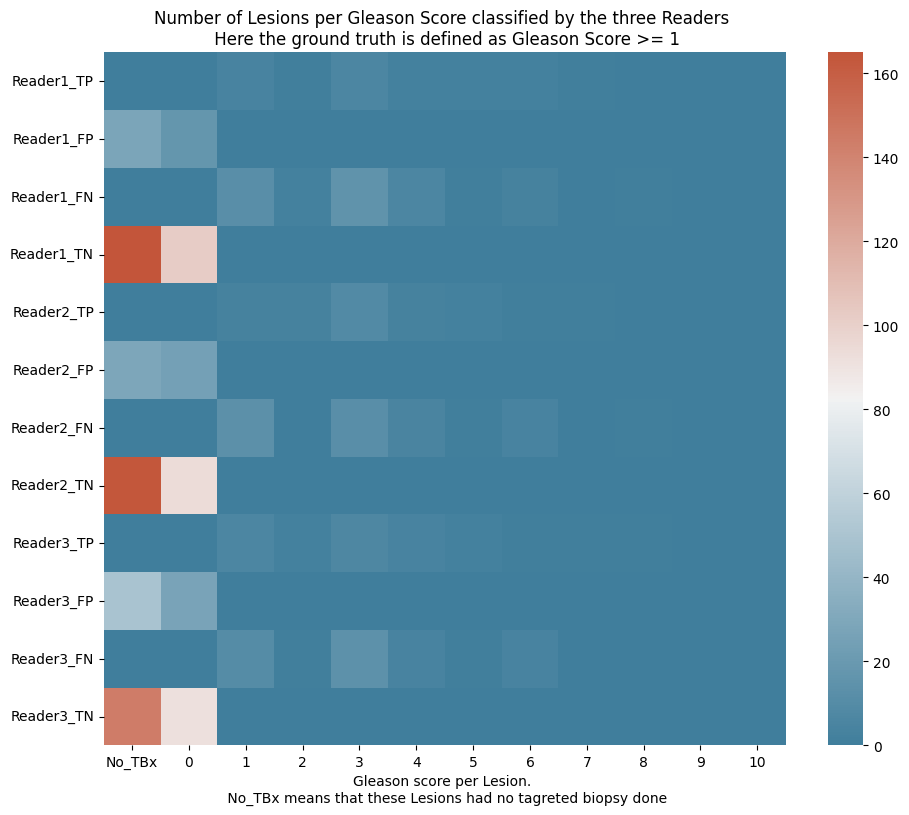

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

readers = ['Reader1',
           'Reader2',
           'Reader3' 
]

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(heat_map_table,cmap=cmap)
plt.xlabel('Gleason score per Lesion. \n No_TBx means that these Lesions had no tagreted biopsy done')
plt.title('Number of Lesions per Gleason Score classified by the three Readers \n Here the ground truth is defined as Gleason Score >= 1')

plt.savefig('Heatmap_Number_of_Lesions_ge1')

In [54]:
#Create a ROC curve for the three readers:

#Sum up the rows in the heatmap table: But only the biopsies
heat_map_table['sum_biopsies'] = ''
for row in heat_map_table.index:
    sum = 0
    for col in heat_map_table.columns:
        if col != 'sum_biopsies' and col != 'No_TBx':
            sum = sum + heat_map_table.loc[row,col]
    heat_map_table.loc[row,'sum_biopsies'] = sum

heat_map_table.to_excel('Heatmap_table_Number_of_Lesions_ge1.xlsx')

#Calculate the specificity and sensitivity and Accuracy:

def Specificity(TP,FP):
    return round(TP/(TP+FP),2)
  
def Sensitivity(TP,FN):
    return round(TP/(TP+FN),2)

def Accuracy(TP,FP,FN,TN):
    return round((TP+TN)/(TP+TN+FP+FN),2)


print('For Gleason score >= 1 as ground truth:\n\n')
#Reader 1:
print('Reader 1, Specificity: ' + str(Specificity(heat_map_table.loc['Reader1_TP','sum_biopsies'], heat_map_table.loc['Reader1_FP','sum_biopsies'])) + '\n \t  Sensitivity: ' + str(Sensitivity(heat_map_table.loc['Reader1_TP','sum_biopsies'], heat_map_table.loc['Reader1_FN','sum_biopsies'])))   
print('\t  Accuracy: ' + str(Accuracy(heat_map_table.loc['Reader1_TP','sum_biopsies'], heat_map_table.loc['Reader1_FP','sum_biopsies'],heat_map_table.loc['Reader1_FN','sum_biopsies'],heat_map_table.loc['Reader1_TN','sum_biopsies'])))
#Reader 2:
print('\nReader 2, Specificity: ' + str(Specificity(heat_map_table.loc['Reader2_TP','sum_biopsies'], heat_map_table.loc['Reader2_FP','sum_biopsies'])) + '\n \t  Sensitivity: ' + str(Sensitivity(heat_map_table.loc['Reader2_TP','sum_biopsies'], heat_map_table.loc['Reader2_FN','sum_biopsies'])))   
print('\t  Accuracy: ' + str(Accuracy(heat_map_table.loc['Reader2_TP','sum_biopsies'], heat_map_table.loc['Reader2_FP','sum_biopsies'],heat_map_table.loc['Reader2_FN','sum_biopsies'],heat_map_table.loc['Reader2_TN','sum_biopsies'])))

#Reader 3:
print('\nReader 3, Specificity: ' + str(Specificity(heat_map_table.loc['Reader3_TP','sum_biopsies'], heat_map_table.loc['Reader3_FP','sum_biopsies'])) + '\n \t  Sensitivity: ' + str(Sensitivity(heat_map_table.loc['Reader3_TP','sum_biopsies'], heat_map_table.loc['Reader3_FN','sum_biopsies'])))   
print('\t  Accuracy: ' + str(Accuracy(heat_map_table.loc['Reader3_TP','sum_biopsies'], heat_map_table.loc['Reader3_FP','sum_biopsies'],heat_map_table.loc['Reader3_FN','sum_biopsies'],heat_map_table.loc['Reader3_TN','sum_biopsies'])))


For Gleason score >= 1 as ground truth:


Reader 1, Specificity: 0.51
 	  Sensitivity: 0.31
	  Accuracy: 0.68

Reader 2, Specificity: 0.47
 	  Sensitivity: 0.38
	  Accuracy: 0.66

Reader 3, Specificity: 0.47
 	  Sensitivity: 0.41
	  Accuracy: 0.66


# Add the Reader Opinion to the specific Lesion:

In [56]:
#Add to each sextant/quadrant what the Reader classified this leasion as:

TBx_locations = ['TBx_Re_Base',
                        'TBx_Re_Mid',
                        'TBx_Re_Apex',
                        'TBx_Li_Base',
                        'TBx_Li_Mid',
                        'TBx_Li_Apex',
                        'TBx_Li_Lateral',
                        'TBx_Li_Medial',
                        'TBx_Re_Lateral',
                        'TBx_Re_Medial'
]

def True_or_False(string):
    if string == False:
        return 0
    if string == True:
        return 1
    else: return 'test'


for Case in TBx_score_greatereq_1.index:
    if Case == 'Number_of_TBx_greaterequal_1' or Case == 'TBx_score_greatereq_1':
        continue
    ID = TBx_score_greatereq_1.loc[Case,'other_aval_ID']

    for location in TBx_locations:
        if TBx_score_greatereq_1.loc[Case,location] != 'No TBx':
            output = str(TBx_score_greatereq_1.loc[Case,location]) + ' (' + str(True_or_False(benchmark_table.loc[ID,'Reader1_'+ str(location)+'_positive'])) + '.' + str(str(True_or_False(benchmark_table.loc[ID,'Reader2_'+ str(location)+'_positive']))) + '.' + str(str(True_or_False(benchmark_table.loc[ID,'Reader3_'+ str(location)+'_positive']))) + ')'
            TBx_score_greatereq_1.loc[Case,location] = output



TBx_score_greatereq_1.to_excel('TBx_greaterequal_1.xlsx')

# Remove the not used part of the table and create an excel file:

In [132]:
benchmark_table['other_aval_ID'] = benchmark_table.index

C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_19868\3565487187.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benchmark_table['other_aval_ID'] = benchmark_table.index


In [133]:
%%sql Benchmark_contingency_table <<
drop table if exists Benchmark_contingency_table;
CREATE TABLE Benchmark_contingency_table AS
SELECT
Studies_ID,
other_aval_ID,
Site,
Comment,
TBx_Re_Base,
TBx_Re_Mid,
TBx_Re_Apex,
TBx_Li_Base,
TBx_Li_Mid,
TBx_Li_Apex,
TBx_Li_lateral,
TBx_Li_medial,
TBx_Re_lateral,
TBx_Re_medial,
Reader1_TBx_Re_Base,
Reader1_TBx_Re_Mid,
Reader1_TBx_Re_Apex,
Reader1_TBx_Li_Base,
Reader1_TBx_Li_Mid,
Reader1_TBx_Li_Apex,
Reader1_TBx_Li_Lateral,
Reader1_TBx_Li_Medial,
Reader1_TBx_Re_Lateral,
Reader1_TBx_Re_Medial,
Reader2_TBx_Re_Base,
Reader2_TBx_Re_Mid,
Reader2_TBx_Re_Apex,
Reader2_TBx_Li_Base,
Reader2_TBx_Li_Mid,
Reader2_TBx_Li_Apex,
Reader2_TBx_Li_Lateral,
Reader2_TBx_Li_Medial,
Reader2_TBx_Re_Lateral,
Reader2_TBx_Re_Medial,
Reader3_TBx_Re_Base,
Reader3_TBx_Re_Mid,
Reader3_TBx_Re_Apex,
Reader3_TBx_Li_Base,
Reader3_TBx_Li_Mid,
Reader3_TBx_Li_Apex,
Reader3_TBx_Li_Lateral,
Reader3_TBx_Li_Medial,
Reader3_TBx_Re_Lateral,
Reader3_TBx_Re_Medial,
FROM benchmark_table

Running query in 'duckdb:///:memory:'

In [134]:
%%sql benchmark_Case_wise_scores <<
drop table if exists benchmark_Case_wise_scores;
create table benchmark_Case_wise_scores as
select 

Studies_ID,
other_aval_ID,
Site,
Comment,
TBx_Re_Base,
TBx_Re_Mid,
TBx_Re_Apex,
TBx_Li_Base,
TBx_Li_Mid,
TBx_Li_Apex,
TBx_Li_lateral,
TBx_Li_medial,
TBx_Re_lateral,
TBx_Re_medial,
Number_of_TBxs,
Number_of_TBxs_greaterequal_3,
lesions_seen_by_Reader1,
lesions_seen_by_Reader2,
lesions_seen_by_Reader3,
Reader_score,
Reader_agreement_score

from benchmark_table

Running query in 'duckdb:///:memory:'

In [135]:
%%sql
--COPY (SELECT * FROM Benchmark_contingency_table) TO 'Benchmark_contingency_table_ge1.xlsx' WITH (FORMAT GDAL, DRIVER 'xlsx');
COPY (SELECT * FROM benchmark_Case_wise_scores) TO 'Benchmark_Case_wise_scores_ge1.xlsx' WITH (FORMAT GDAL, DRIVER 'xlsx');

Running query in 'duckdb:///:memory:'

,Success
